In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Chargement des données
data = pd.read_csv('airbnb_train.csv')

# Transformation de la colonne log_price si elle n'existe pas
if "log_price" not in data.columns:
    data["log_price"] = np.log1p(data["price"])

# Aperçu des données
data.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,5708593,4.317488,House,Private room,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",3,1.0,Real Bed,flexible,False,...,NaN,33.782712,-118.134410,Island style Spa Studio,Long Beach,0,NaN,90804,0.0,2.0
1,14483613,4.007333,House,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",4,2.0,Real Bed,strict,False,...,2017-09-17,40.705468,-73.909439,"Beautiful and Simple Room W/2 Beds, 25 Mins to...",Ridgewood,38,86.0,11385,1.0,2.0
2,10412649,7.090077,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",6,2.0,Real Bed,flexible,False,...,NaN,38.917537,-77.031651,2br/2ba luxury condo perfect for infant / toddler,U Street Corridor,0,NaN,20009,2.0,2.0
3,17954362,3.555348,House,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,1.0,Real Bed,flexible,True,...,2017-09-29,40.736001,-73.924248,Manhattan view from Queens. Lovely single room .,Sunnyside,19,96.0,11104,1.0,1.0
4,9969781,5.480639,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,moderate,True,...,2017-08-28,37.744896,-122.430665,Zen Captured Noe Valley House,Noe Valley,15,96.0,94131,2.0,2.0


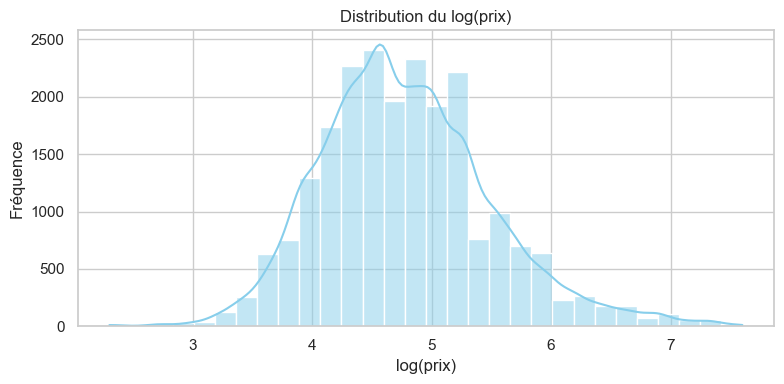

In [53]:
plt.figure(figsize=(8, 4))
sns.histplot(data['log_price'], bins=30, kde=True, color='skyblue')
plt.title('Distribution du log(prix)')
plt.xlabel('log(prix)')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()


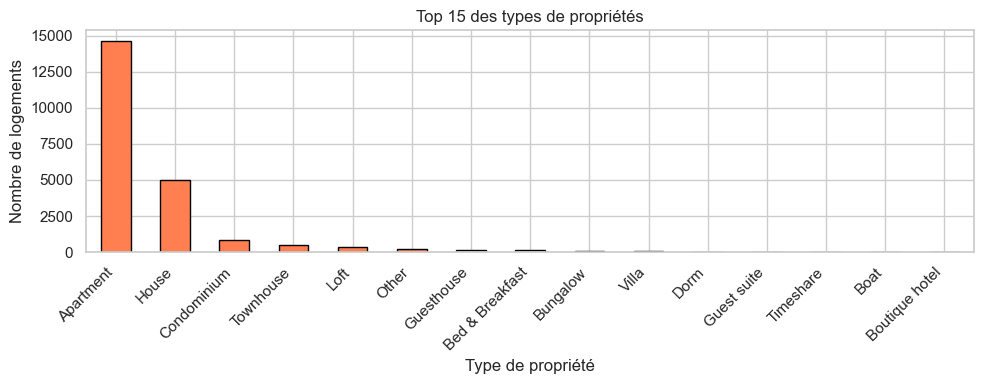

In [54]:
plt.figure(figsize=(10, 4))
data['property_type'].value_counts().head(15).plot(kind='bar', color='coral', edgecolor='black')
plt.title('Top 15 des types de propriétés')
plt.xlabel('Type de propriété')
plt.ylabel('Nombre de logements')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

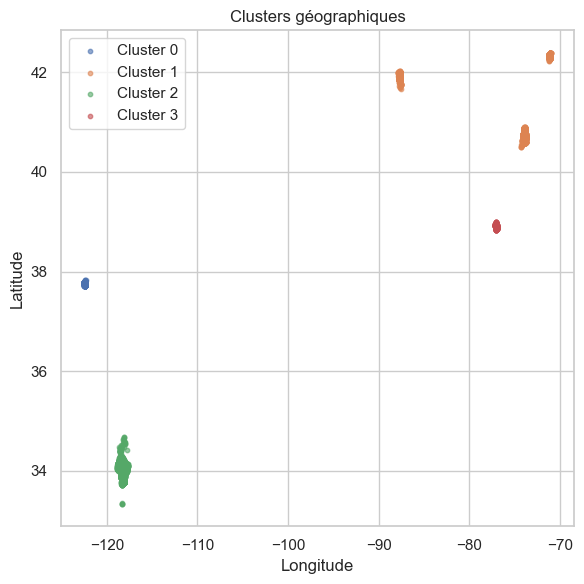

In [55]:
coords = data[['latitude', 'longitude']].dropna()
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(coords_scaled)
data['geo_cluster'] = np.nan
data.loc[coords.index, 'geo_cluster'] = clusters

# Visualisation des clusters géographiques
plt.figure(figsize=(6, 6))
for c in sorted(data['geo_cluster'].dropna().unique()):
    cluster_data = data[data['geo_cluster'] == c]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {int(c)}', s=10, alpha=0.6)
plt.title('Clusters géographiques')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.tight_layout()
plt.show()


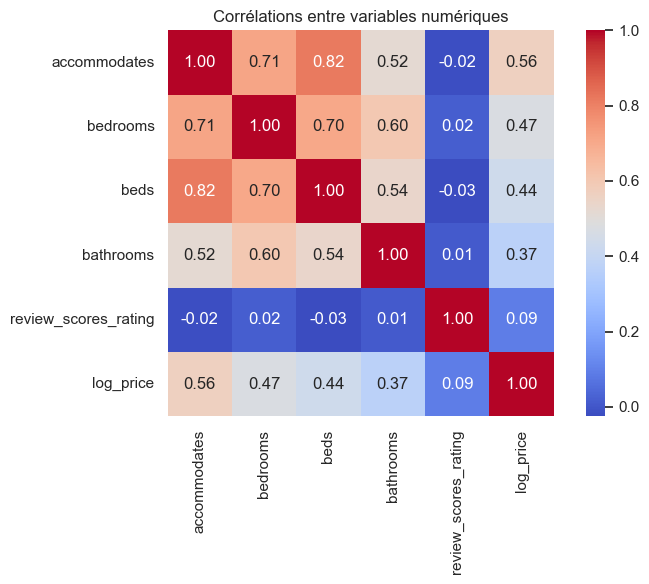

In [56]:
num_vars = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'review_scores_rating', 'log_price']
plt.figure(figsize=(8, 6))
corr = data[num_vars].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Corrélations entre variables numériques")
plt.tight_layout()
plt.show()

In [57]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# Fonction pour traiter les colonnes 'amenities'
def process_amenities_column(df, top_n=50):
    df = df.copy()
    df["amenities"] = df["amenities"].fillna("[]")
    all_amenities = df["amenities"].str.replace(r"[{}\"]", "", regex=True).str.split(",")
    amenities_flat = [item.strip() for sublist in all_amenities for item in sublist]
    top_amenities = pd.Series(amenities_flat).value_counts().head(top_n).index.tolist()
    for amenity in top_amenities:
        df[f"amenity_{amenity}"] = all_amenities.apply(lambda x: int(amenity in x))
    return df, [f"amenity_{a}" for a in top_amenities]

# Traitement des données
airbnb, amenity_columns = process_amenities_column(data, top_n=20)

# Sélection des colonnes
selected_columns = [
    "accommodates", "bedrooms", "beds", "bed_type", "room_type", "bathrooms",
    "cleaning_fee", "city", "review_scores_rating", "instant_bookable",
    "cancellation_policy", "property_type"
] + amenity_columns

X = airbnb[selected_columns].copy()
y = airbnb["log_price"]

# Séparation des colonnes numériques et catégoriques
numerical_columns = ["accommodates", "bedrooms", "beds", "bathrooms", "review_scores_rating"] + amenity_columns
categorical_columns = list(set(selected_columns) - set(numerical_columns))

# Remplissage des valeurs manquantes
for col in numerical_columns:
    X[col] = X[col].fillna(0)
for col in categorical_columns:
    X[col] = X[col].fillna("missing")

In [58]:
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)
])
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"Scores de validation croisée : {cv_scores}")
print(f"R² moyen (validation croisée) : {np.mean(cv_scores):.4f}")

model.fit(X_train, y_train)

Scores de validation croisée : [0.55501486 0.55820327 0.57775315 0.57463327 0.53875729]
R² moyen (validation croisée) : 0.5609


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95))]),
                                                  ['accommodates', 'bedrooms',
                                                   'beds', 'bathrooms',
                                                   'review_scores_rating',
                                                   'amenity_Wireless Internet',
                                                   'amenity_Kitchen',
                                                   'amenity_Heating',
                                                   'amenity_Essentials',
                                                   'ame...
                                                   'amenity_translation '
                                                   'missing: '
                                                   'en.hosting_amenity_50']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['cancellation_policy',
                                                   'property_type', 'bed_type',
                                                   'city', 'instant_bookable',
                                                   'room_type',
                                                   'cleaning_fee'])])),
                ('regressor', LinearRegression())])

In [60]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

# Évaluation sur l'ensemble d'entraînement
print("\n=== Évaluation sur l'ensemble d'entraînement ===")
evaluate_model(y_train, model.predict(X_train))

# Évaluation sur l'ensemble de test
print("\n=== Évaluation sur l'ensemble de test ===")
evaluate_model(y_test, model.predict(X_test))


=== Évaluation sur l'ensemble d'entraînement ===
RMSE: 0.4742
R²: 0.5655

=== Évaluation sur l'ensemble de test ===
RMSE: 0.4763
R²: 0.5571


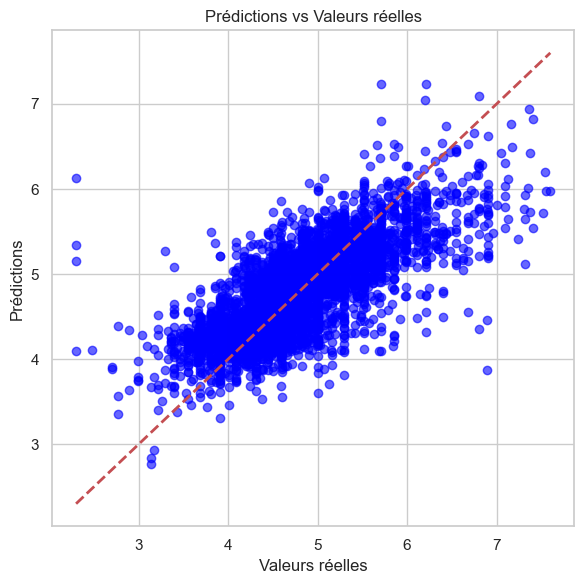

In [61]:
# Visualisation des prédictions vs valeurs réelles
y_pred = model.predict(X_test)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title("Prédictions vs Valeurs réelles")
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.tight_layout()
plt.show()